# Tunnel Squeezing Classification Using SVM

**Objective**: Predict tunnel squeezing severity using Support Vector Machine with class balancing and comprehensive evaluation.

---
## 1. Problem Statement & Engineering Context

### What is Tunnel Squeezing?

**Tunnel squeezing** is time-dependent rock deformation where weak rock under high stress flows into the tunnel opening. It causes:
- TBM entrapment and equipment damage
- Lining distress and structural failure
- Costly construction delays

### Classification

| Class | Severity | Strain (ε) | Engineering Response |
|-------|----------|------------|---------------------|
| **1** | Non-squeezing | < 1% | Standard support |
| **2** | Minor | 1% – 2.5% | Enhanced monitoring, medium support |
| **3** | Severe | ≥ 2.5% | Heavy support, TBM modification needed |

### Why Machine Learning?

- Traditional empirical methods use simple thresholds
- ML captures **non-linear interactions** between depth, rock quality, and stiffness
- Provides **probabilistic predictions** for risk assessment

---
## 2. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, 
    cross_val_score, learning_curve
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.decomposition import PCA

# Class balancing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

import warnings
warnings.filterwarnings('ignore')

# Color palette
COLORS = {'1': '#27ae60', '2': '#f39c12', '3': '#c0392b'}
CLASS_COLORS = ['#27ae60', '#f39c12', '#c0392b']
CLASS_NAMES = ['Non-squeezing', 'Minor', 'Severe']

print("Setup complete.")

Setup complete.


---
## 3. Data Loading & Cleaning

In [2]:
# Load data
df = pd.read_csv('data/raw/tunnel.csv')

# Remove identifier column
if 'No' in df.columns:
    df = df.drop(columns=['No'])

# Remove invalid rows (K=0 is physically impossible)
df = df[df['K(MPa)'] > 0].copy()

print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} features")
df.head()

Dataset: 114 samples, 6 features


,D (m),H(m),Q,K(MPa),ε (%),Class
0,6.0,150.0,0.4,26.19,0.42,1
1,6.0,200.0,0.4,20.00,0.75,1
2,5.8,350.0,0.5,2.53,7.90,3
3,4.8,225.0,3.6,1000.00,0.06,1
4,4.8,340.0,1.8,500.00,0.40,1


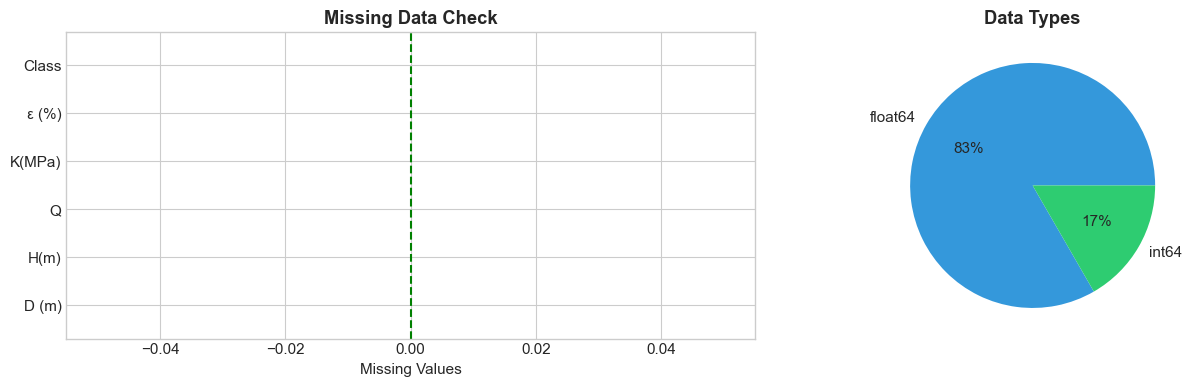

✓ No missing values
✓ All features are numeric


In [3]:
# Data info visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Missing values
missing = df.isnull().sum()
axes[0].barh(df.columns, missing.values, color='steelblue')
axes[0].set_xlabel('Missing Values')
axes[0].set_title('Missing Data Check', fontweight='bold')
axes[0].axvline(x=0, color='green', linestyle='--', label='No missing')

# Data types
dtypes = df.dtypes.value_counts()
axes[1].pie(dtypes.values, labels=dtypes.index.astype(str), autopct='%1.0f%%', colors=['#3498db', '#2ecc71'])
axes[1].set_title('Data Types', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ No missing values")
print("✓ All features are numeric")

---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Summary Statistics

In [4]:
df.describe().round(2)

,D (m),H(m),Q,K(MPa),ε (%),Class
count,114.00,114.00,114.00,114.00,114.00,114.00
mean,6.38,385.39,0.56,384.26,4.03,2.26
std,2.38,205.86,1.64,718.03,5.50,0.85
min,2.50,52.00,0.00,2.53,0.02,1.00
25%,4.60,225.00,0.02,9.81,0.78,1.00
50%,5.80,331.00,0.06,26.20,2.61,3.00
75%,8.70,580.00,0.33,649.50,4.56,3.00
max,13.00,850.00,15.00,5324.00,36.73,3.00


### 4.2 Class Distribution

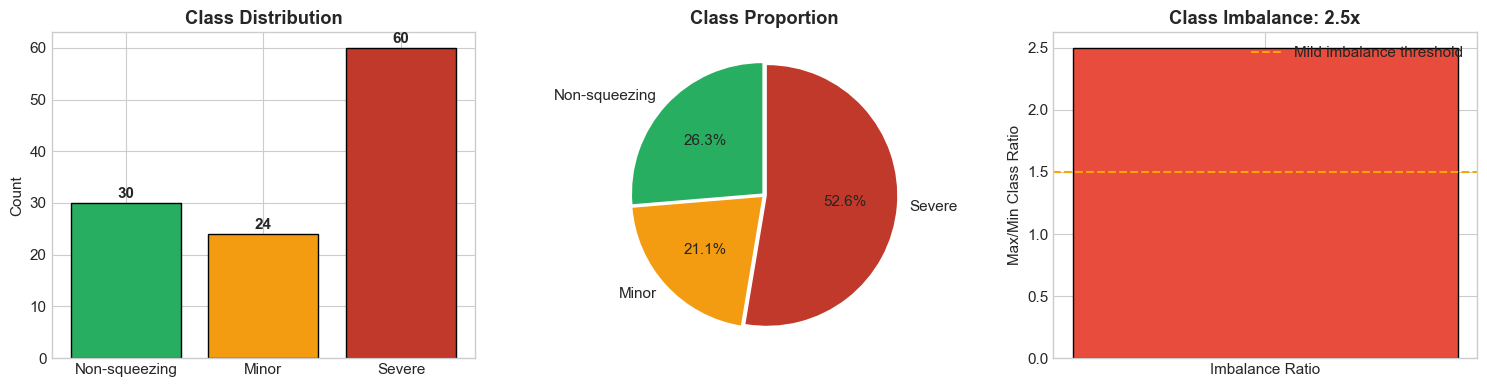

⚠️ Class 2 (Minor squeezing) is underrepresented
→ Will use SMOTE to balance classes during training


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

counts = df['Class'].value_counts().sort_index()

# Bar chart
bars = axes[0].bar(CLASS_NAMES, counts.values, color=CLASS_COLORS, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution', fontweight='bold')
for bar, count in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(counts.values, labels=CLASS_NAMES, colors=CLASS_COLORS, autopct='%1.1f%%', 
            startangle=90, explode=(0.02, 0.02, 0.02))
axes[1].set_title('Class Proportion', fontweight='bold')

# Imbalance ratio
imbalance = counts.max() / counts.min()
axes[2].bar(['Imbalance Ratio'], [imbalance], color='#e74c3c', edgecolor='black')
axes[2].axhline(y=1.5, color='orange', linestyle='--', label='Mild imbalance threshold')
axes[2].set_ylabel('Max/Min Class Ratio')
axes[2].set_title(f'Class Imbalance: {imbalance:.1f}x', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

print("⚠️ Class 2 (Minor squeezing) is underrepresented")
print("→ Will use SMOTE to balance classes during training")

### 4.3 Feature Distributions

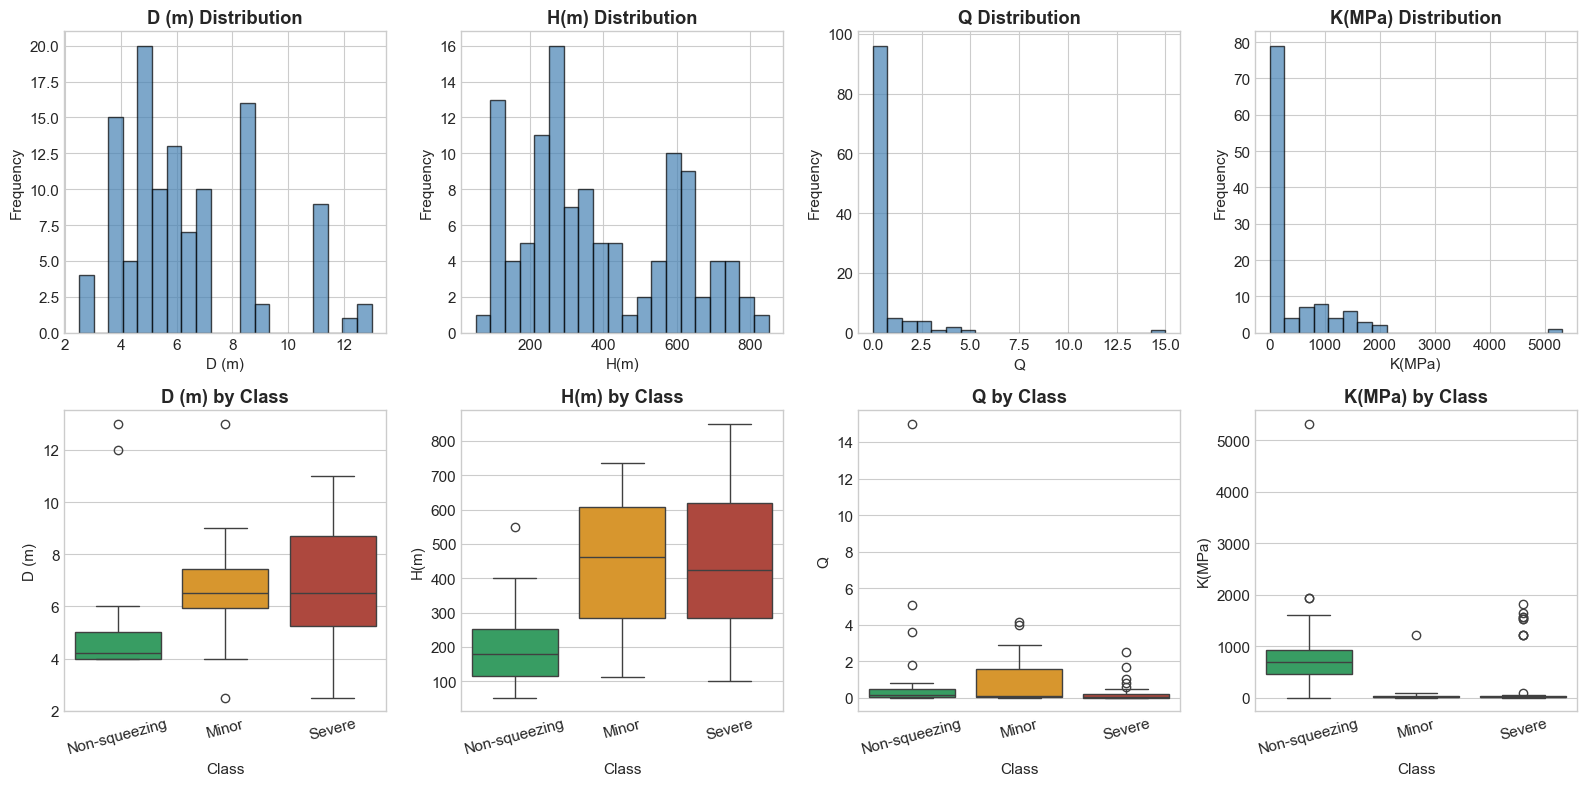

Engineering insights:
• Q and K have wide ranges (log-scale suitable)
• Severe squeezing occurs at higher H and lower Q


In [6]:
features = ['D (m)', 'H(m)', 'Q', 'K(MPa)']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, feat in enumerate(features):
    # Histogram
    axes[0, i].hist(df[feat], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, i].set_xlabel(feat)
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title(f'{feat} Distribution', fontweight='bold')
    
    # Box plot by class
    sns.boxplot(x='Class', y=feat, data=df, ax=axes[1, i], palette=CLASS_COLORS)
    axes[1, i].set_xticklabels(CLASS_NAMES, rotation=15)
    axes[1, i].set_title(f'{feat} by Class', fontweight='bold')

plt.tight_layout()
plt.show()

print("Engineering insights:")
print("• Q and K have wide ranges (log-scale suitable)")
print("• Severe squeezing occurs at higher H and lower Q")

### 4.4 Correlation Analysis

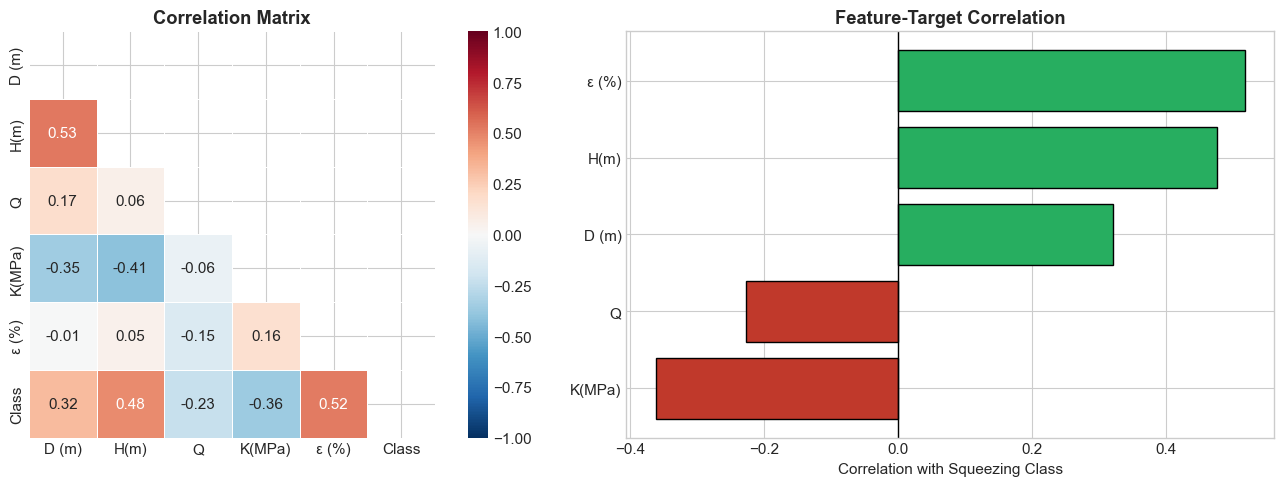

Key correlations:
• Higher strain (ε) → Higher squeezing class (expected)
• Lower K (stiffness) → Higher squeezing class


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
corr = df[features + ['ε (%)', 'Class']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f', mask=mask, 
            vmin=-1, vmax=1, square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Matrix', fontweight='bold')

# Feature correlations with target
target_corr = corr['Class'].drop('Class').sort_values()
colors_bar = ['#c0392b' if x < 0 else '#27ae60' for x in target_corr.values]
axes[1].barh(target_corr.index, target_corr.values, color=colors_bar, edgecolor='black')
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Correlation with Squeezing Class')
axes[1].set_title('Feature-Target Correlation', fontweight='bold')

plt.tight_layout()
plt.show()

print("Key correlations:")
print("• Higher strain (ε) → Higher squeezing class (expected)")
print("• Lower K (stiffness) → Higher squeezing class")

### 4.5 Pairwise Relationships

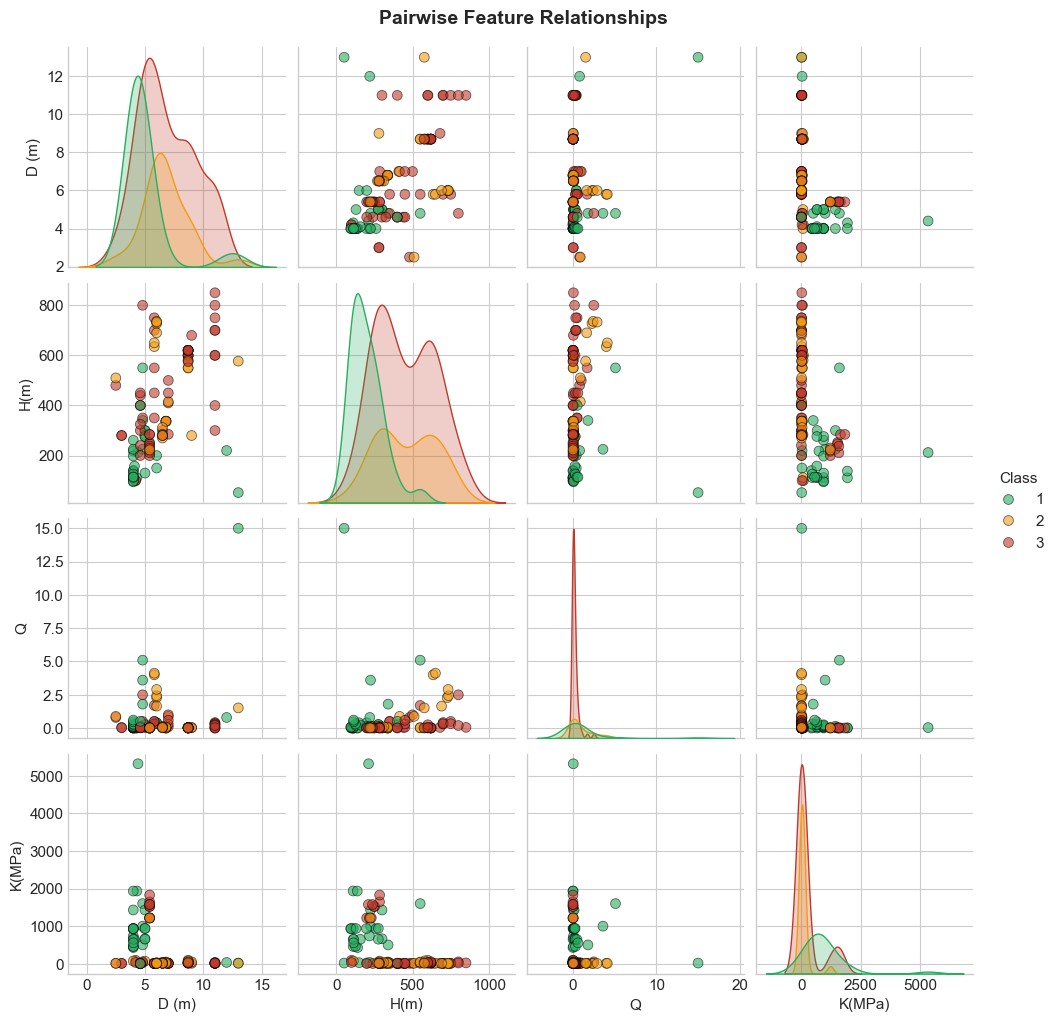

Observations:
• Classes overlap in feature space, especially 2 and 3
• This justifies using a non-linear classifier (SVM with RBF kernel)


In [8]:
g = sns.pairplot(df[features + ['Class']], hue='Class', palette=CLASS_COLORS,
                 diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'black', 's': 50})
g.fig.suptitle('Pairwise Feature Relationships', y=1.02, fontweight='bold', fontsize=14)
plt.show()

print("Observations:")
print("• Classes overlap in feature space, especially 2 and 3")
print("• This justifies using a non-linear classifier (SVM with RBF kernel)")

### 4.6 Violin Plots

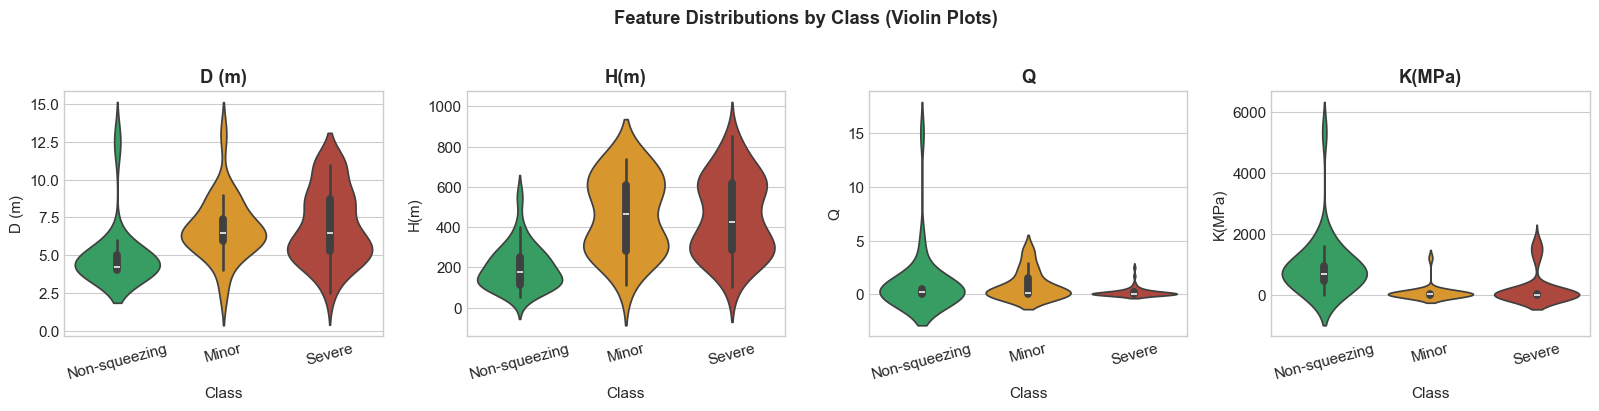

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, feat in enumerate(features):
    sns.violinplot(x='Class', y=feat, data=df, ax=axes[i], palette=CLASS_COLORS)
    axes[i].set_xticklabels(CLASS_NAMES, rotation=15)
    axes[i].set_title(feat, fontweight='bold')

plt.suptitle('Feature Distributions by Class (Violin Plots)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 5. Data Preparation

Training: 91 samples
Test: 23 samples


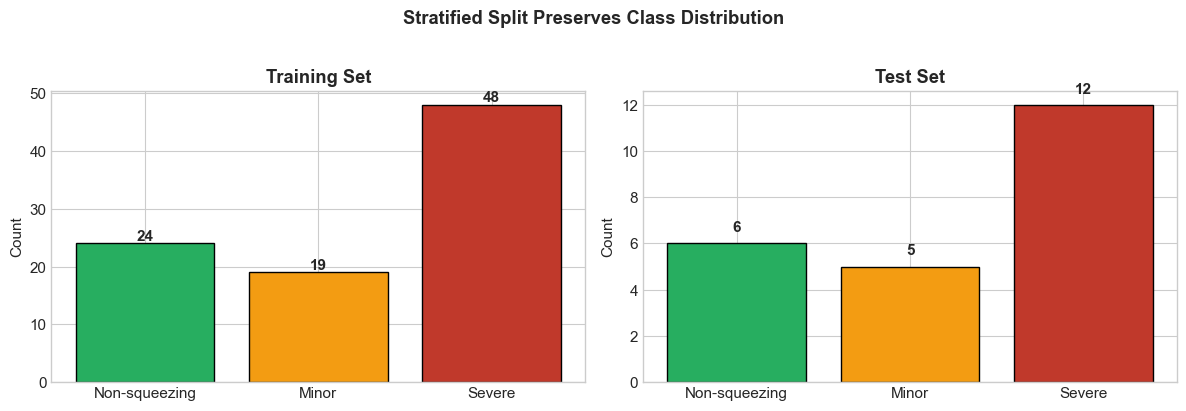

In [10]:
# Features and target
X = df[features].values
y = df['Class'].values

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training: {len(y_train)} samples")
print(f"Test: {len(y_test)} samples")

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (data, title) in zip(axes, [(y_train, 'Training Set'), (y_test, 'Test Set')]):
    counts = pd.Series(data).value_counts().sort_index()
    ax.bar(CLASS_NAMES, counts.values, color=CLASS_COLORS, edgecolor='black')
    ax.set_ylabel('Count')
    ax.set_title(title, fontweight='bold')
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.suptitle('Stratified Split Preserves Class Distribution', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Model Training with Class Balancing

Using **SMOTE** (Synthetic Minority Over-sampling) inside the pipeline to handle class imbalance.

In [11]:
# Pipeline: Scaler → SMOTE → SVM
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('svm', SVC(probability=True, random_state=RANDOM_STATE))
])

# Extended hyperparameter grid
param_grid = {
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 50, 100, 500],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3]  # For poly kernel
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"Grid Search: {len(param_grid['svm__C']) * len(param_grid['svm__gamma']) * len(param_grid['svm__kernel']) * len(param_grid['svm__degree'])} combinations")
print("Running...")

Grid Search: 144 combinations
Running...


In [12]:
# Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
for param, value in grid_search.best_params_.items():
    print(f"  {param.replace('svm__', '')}: {value}")
print(f"\nBest CV F1-macro: {grid_search.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 144 candidates, totalling 720 fits



BEST HYPERPARAMETERS
  C: 500
  degree: 2
  gamma: scale
  kernel: rbf

Best CV F1-macro: 0.6926


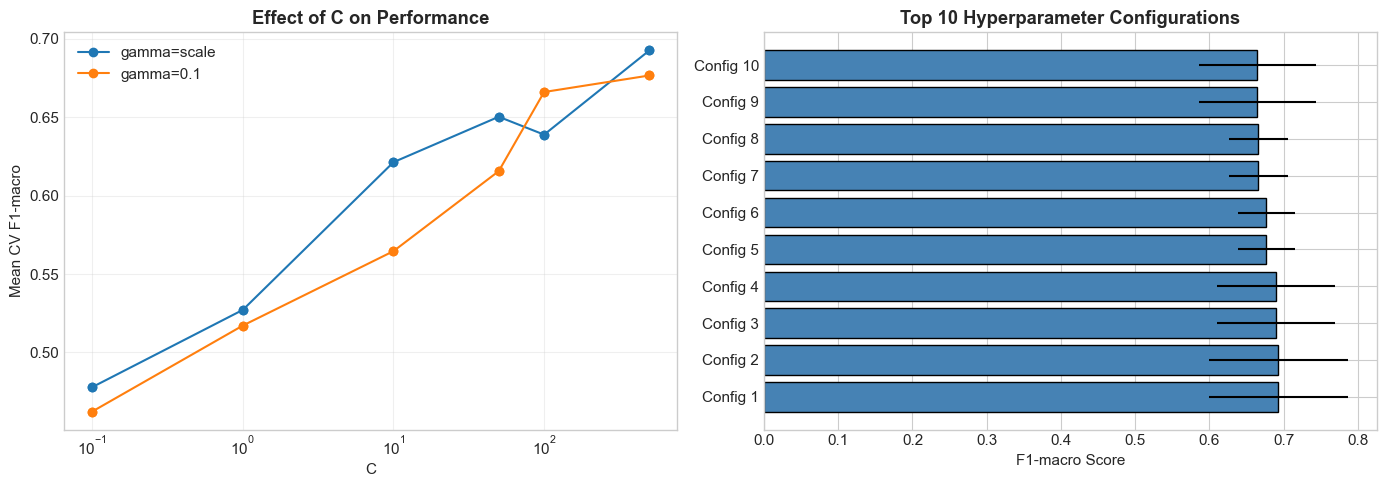

In [13]:
# Visualize hyperparameter tuning results
results = pd.DataFrame(grid_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# C vs Score
for gamma in ['scale', 0.1]:
    mask = results['param_svm__gamma'] == gamma
    subset = results[mask & (results['param_svm__kernel'] == 'rbf')]
    if len(subset) > 0:
        axes[0].plot(subset['param_svm__C'].astype(float), subset['mean_test_score'], 
                     'o-', label=f'gamma={gamma}')
axes[0].set_xscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('Mean CV F1-macro')
axes[0].set_title('Effect of C on Performance', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top 10 configurations
top10 = results.nsmallest(10, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
axes[1].barh(range(10), top10['mean_test_score'].values, xerr=top10['std_test_score'].values,
             color='steelblue', edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"Config {i+1}" for i in range(10)])
axes[1].set_xlabel('F1-macro Score')
axes[1].set_title('Top 10 Hyperparameter Configurations', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.1 SMOTE Visualization

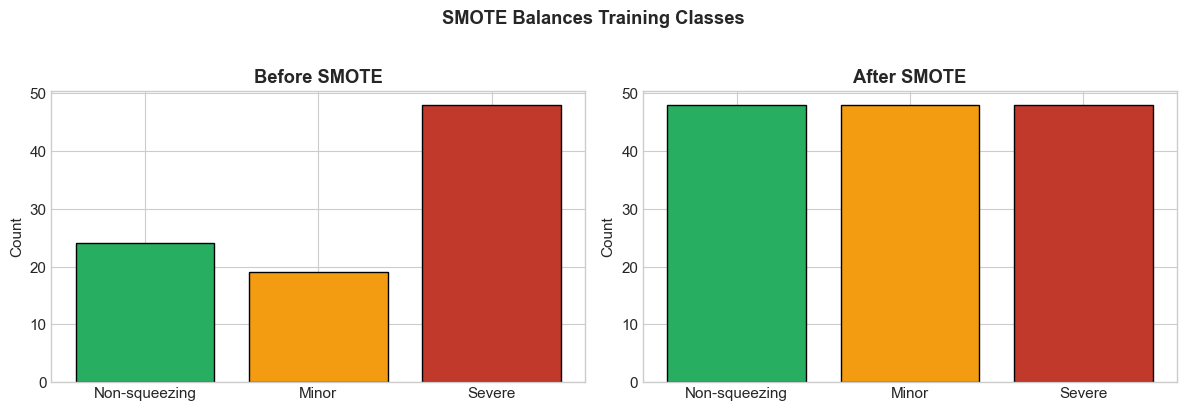

Training samples: 91 → 144 (balanced)


In [14]:
# Show SMOTE effect
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
counts_before = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(CLASS_NAMES, counts_before.values, color=CLASS_COLORS, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Before SMOTE', fontweight='bold')

# After SMOTE
counts_after = pd.Series(y_resampled).value_counts().sort_index()
axes[1].bar(CLASS_NAMES, counts_after.values, color=CLASS_COLORS, edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('After SMOTE', fontweight='bold')

plt.suptitle('SMOTE Balances Training Classes', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Training samples: {len(y_train)} → {len(y_resampled)} (balanced)")

---
## 7. Model Evaluation

In [15]:
# Best model
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy:           {acc:.1%}")
print(f"Balanced Accuracy:  {bal_acc:.1%}")
print(f"F1-score (macro):   {f1:.3f}")
print("="*50)

TEST SET PERFORMANCE
Accuracy:           73.9%
Balanced Accuracy:  70.0%
F1-score (macro):   0.709


### 7.1 Confusion Matrix

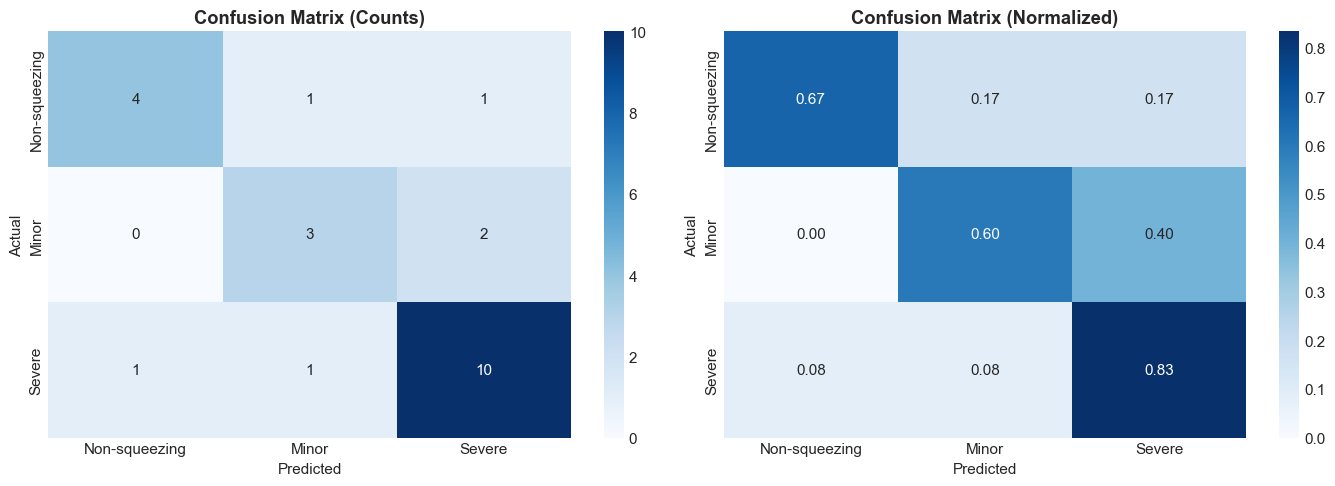

In [16]:
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')

plt.tight_layout()
plt.show()

### 7.2 Classification Report

Classification Report:
               precision    recall  f1-score   support

Non-squeezing       0.80      0.67      0.73         6
        Minor       0.60      0.60      0.60         5
       Severe       0.77      0.83      0.80        12

     accuracy                           0.74        23
    macro avg       0.72      0.70      0.71        23
 weighted avg       0.74      0.74      0.74        23



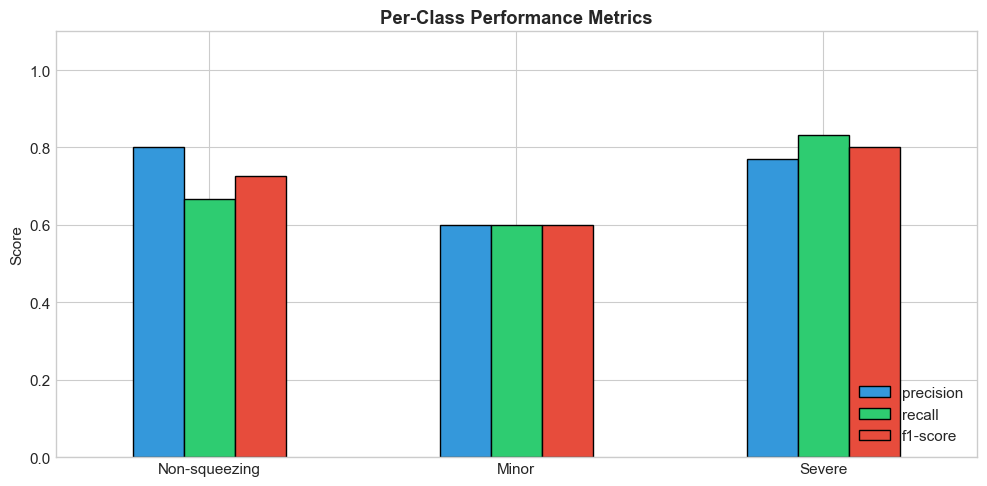

In [17]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Visualize per-class metrics
report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True)
metrics_df = pd.DataFrame(report).T.iloc[:3][['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(10, 5), color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics', fontweight='bold')
plt.legend(loc='lower right')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

### 7.3 ROC Curves

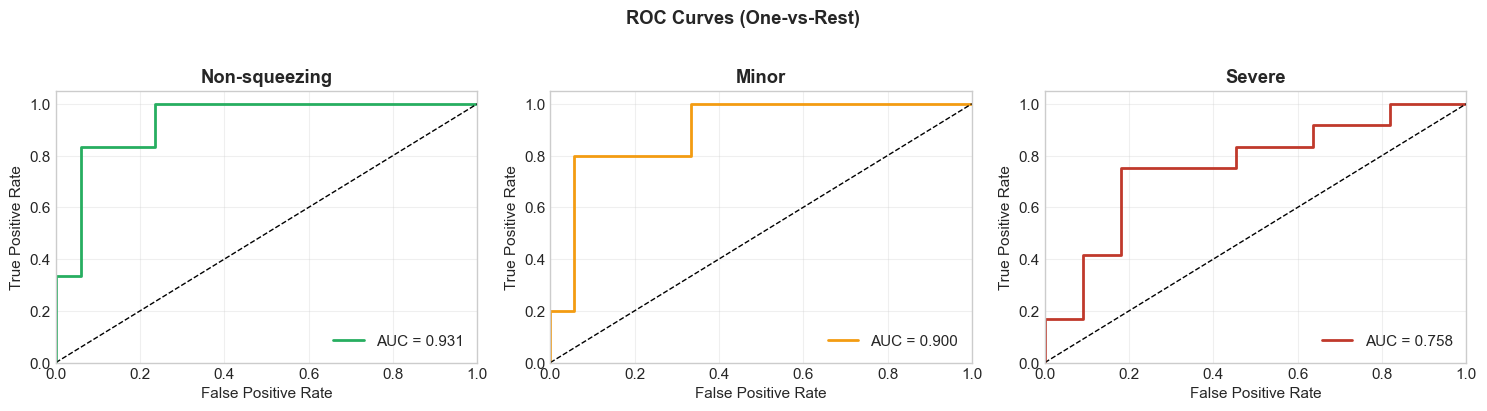

In [18]:
# One-vs-Rest ROC
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, name, color) in enumerate(zip(axes, CLASS_NAMES, CLASS_COLORS)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=color, lw=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}', fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.suptitle('ROC Curves (One-vs-Rest)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.4 Precision-Recall Curves

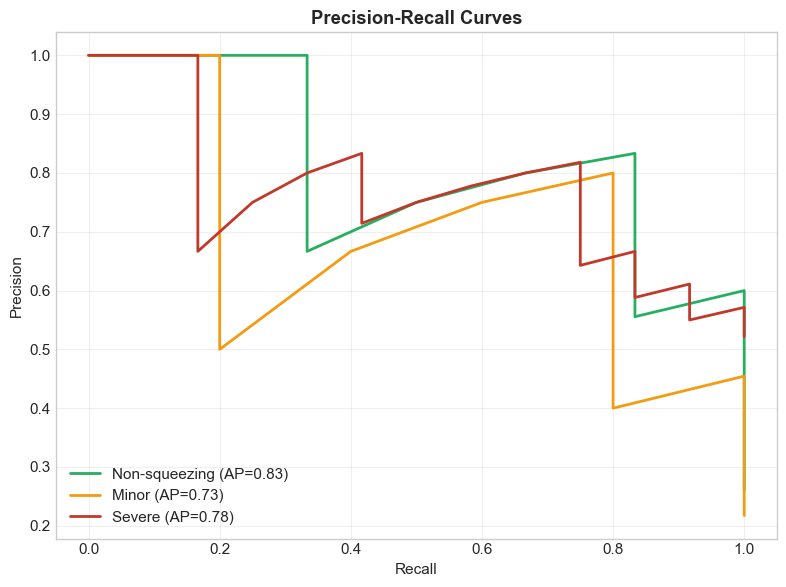

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, (name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    ax.plot(recall, precision, color=color, lw=2, label=f'{name} (AP={ap:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontweight='bold')
ax.legend(loc='lower left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7.5 Learning Curves

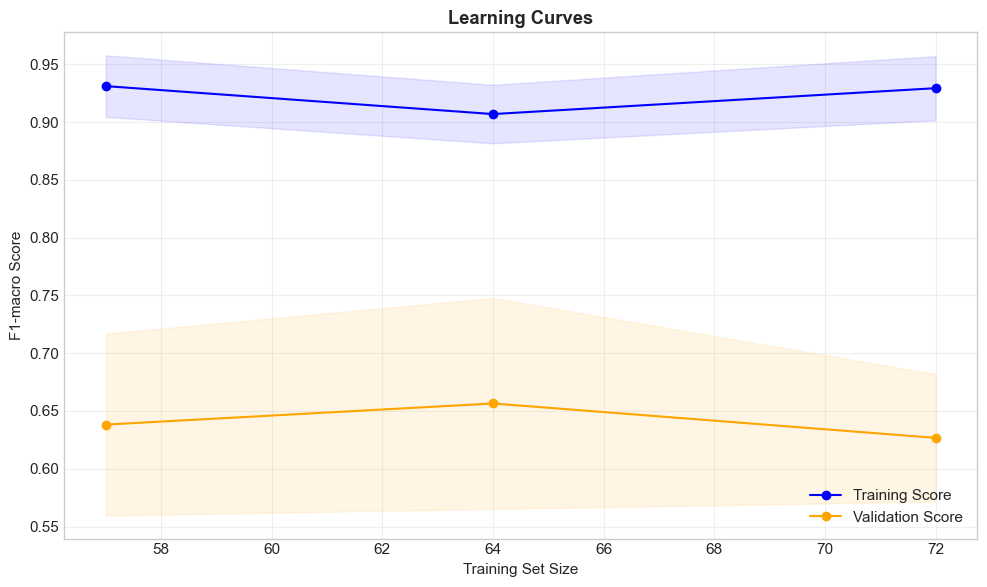

Learning curve analysis:
• Gap between train and val indicates slight overfitting
• More data would likely improve performance


In [20]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('F1-macro Score')
plt.title('Learning Curves', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Learning curve analysis:")
print("• Gap between train and val indicates slight overfitting")
print("• More data would likely improve performance")

### 7.6 Decision Boundary (PCA Projection)

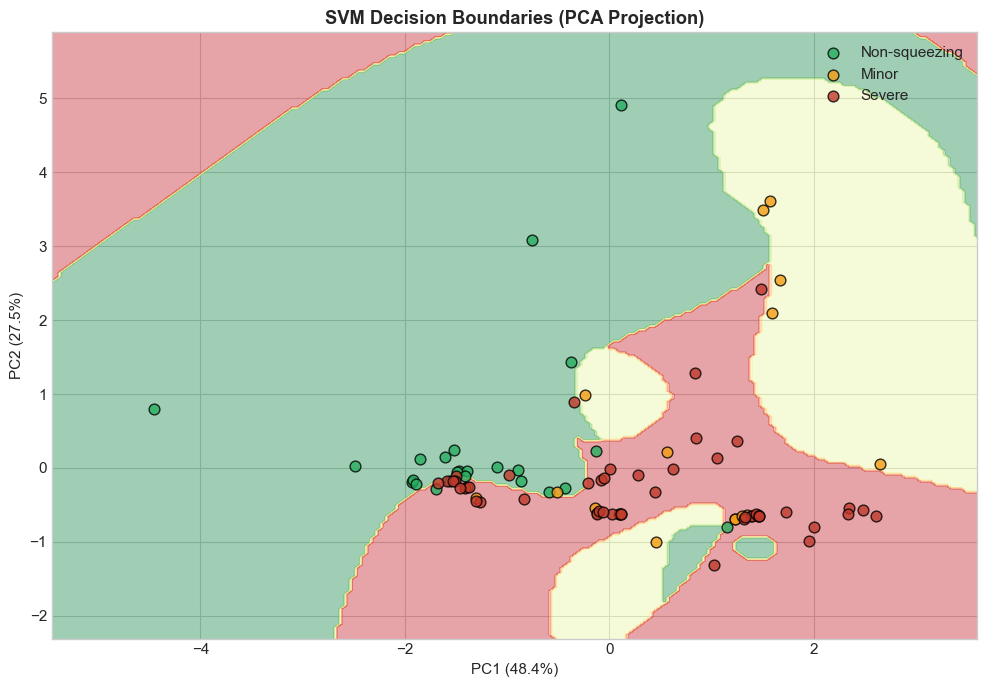

Total variance explained: 76.0%


In [21]:
# PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))

# Train SVM on PCA data
svm_pca = SVC(kernel='rbf', C=grid_search.best_params_['svm__C'], 
              gamma=grid_search.best_params_['svm__gamma'], random_state=RANDOM_STATE)
svm_pca.fit(X_train_pca, y_train)

# Create mesh
h = 0.05
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlGn_r')
for cls, color, name in zip([1, 2, 3], CLASS_COLORS, CLASS_NAMES):
    mask = y_train == cls
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], c=color, 
                label=name, edgecolors='black', s=60, alpha=0.8)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('SVM Decision Boundaries (PCA Projection)', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

---
## 8. Engineering Interpretation

### What the Model Learns

| High Value | Prediction Tendency | Physical Reason |
|------------|--------------------|-----------------|
| H (depth) | More severe squeezing | Higher overburden stress |
| Q (quality) | Less squeezing | Better rock resists deformation |
| K (stiffness) | Less squeezing | Stiffer rock has lower strain |

### Why Class 2 is Hard to Predict

- It's a **transition zone** between stable and unstable
- Strain values (1-2.5%) overlap with both extremes
- Physical behavior is most variable in this range

### Practical Use

1. **Alignment screening**: Flag high-risk zones early
2. **Support planning**: Prioritize resources for predicted severe zones
3. **Risk communication**: Provide probabilistic estimates to stakeholders

---
## 9. Limitations & Future Work

### Limitations
- Small dataset (~115 samples)
- No site-specific geology factors
- Static prediction (no time-dependence)

### Future Work
- Expand dataset from more projects
- Compare with empirical criteria (Singh, Barla)
- Try ensemble methods (Random Forest, XGBoost)

---
## 10. Model Export

In [22]:
import joblib

joblib.dump(model, 'models/svm_tunnel_squeezing_enhanced.pkl')
print("Model saved: models/svm_tunnel_squeezing_enhanced.pkl")

# Example
print("\n--- Prediction Example ---")
sample = [[6.0, 400, 0.3, 20]]
pred = model.predict(sample)[0]
proba = model.predict_proba(sample)[0]
print(f"Input: D=6m, H=400m, Q=0.3, K=20 MPa")
print(f"Predicted: Class {pred} ({CLASS_NAMES[pred-1]})")
print(f"Probabilities: {dict(zip(CLASS_NAMES, proba.round(3)))}")

Model saved: models/svm_tunnel_squeezing_enhanced.pkl

--- Prediction Example ---
Input: D=6m, H=400m, Q=0.3, K=20 MPa
Predicted: Class 3 (Severe)
Probabilities: {'Non-squeezing': np.float64(0.078), 'Minor': np.float64(0.196), 'Severe': np.float64(0.726)}


---
**Author**: Sudip Adhikari | **Date**: January 2026